# First looks can be deceiving


Hi there! Welcome back! This is part 4 of a series on Deep Learning for image classification. In the three previous installments we learnt about [imagenet and deep learning], [the train-test split], and trained a [first classifier] than can tell hotdogs from nothotdogs with near 90% accuracy. 


But wait! Now that I come to think of it, we have 120 hotdog images and 794 nohotdog images in our validation set, so a lazy classifier that assigns everything a 'nothotdog' label would get around 87% accuracy. Let's check if that's the case.

[imagenet and deep learning]: http://mateos.io/blog/getting-some-hotdogs/
[the train-test split]: http://mateos.io/blog/train-test-split/
[first classifier]: TODO link to third part of the series.

# Recap 

On the previous installment, we trained a first Convolutional Neural Network. In order to get to the same state, we need to either a) rerun the code in the same environment, or b) reload previously saved variables. In the interest of a self-contained tutorial, I'm just going to provide here the code to replicate the state we had at the end [last time]. If you want to understand this code, there is a lot of explanation there.

[previous installment]: TODO link to third part of the series.
[last time]:  TODO link to third part of the series.

In [1]:
# Import 
import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, InputLayer, Flatten, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import os

# Download the data
!wget -q "https://www.dropbox.com/s/dhpekpce05iev6a/data_v2.zip?dl=0" -O data.zip
!rm -rf data/
!unzip -oq data.zip
!ls -lh data

# Design the net
my_first_cnn = keras.Sequential()
my_first_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)))
my_first_cnn.add(MaxPooling2D((2,2)))
my_first_cnn.add(Conv2D(32, (3, 3), activation='relu'))
my_first_cnn.add(MaxPooling2D((2,2)))
my_first_cnn.add(Flatten())
my_first_cnn.add(Dense(64, activation='relu'))
my_first_cnn.add(Dense(1, activation='sigmoid'))

# Data generators
base_dir = 'data//'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_datagen = ImageDataGenerator(rescale=1 / 255)
test_datagen = ImageDataGenerator(rescale=1 / 255)
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(120,120),
                                                    batch_size=100,
                                                    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(120,120),
                                                        batch_size=100,
                                                        class_mode='binary')

# Compile and train
my_first_cnn.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-3),
                     metrics=['acc'])

history = my_first_cnn.fit_generator(train_generator,
                                     steps_per_epoch=30,
                                     epochs=10,
                                     validation_data=validation_generator,
                                     validation_steps=10)

# Save the model. If you did this last time, you could skip the training and do:
# from keras.models import load_model
# my_first_cnn = load_model('my_first_cnn.h5')
my_first_cnn.save('my_first_cnn.h5')

Using TensorFlow backend.


total 12K
drwxrwxr-x 4 root root 4.0K Jun 27  2018 test
drwxrwxr-x 4 root root 4.0K Jun 27  2018 train
drwxrwxr-x 4 root root 4.0K Jun 27  2018 validation
Instructions for updating:
Colocations handled automatically by placer.
Found 4765 images belonging to 2 classes.
Found 888 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
30/30 [==============================] - 24s 793ms/step - loss: 0.5728 - acc: 0.8663 - val_loss: 0.3333 - val_acc: 0.8725
Epoch 2/10
30/30 [==============================] - 21s 711ms/step - loss: 0.2950 - acc: 0.8821 - val_loss: 0.3028 - val_acc: 0.8664
Epoch 3/10
30/30 [==============================] - 20s 674ms/step - loss: 0.2935 - acc: 0.8750 - val_loss: 0.2783 - val_acc: 0.8846
Epoch 4/10
30/30 [==============================] - 20s 682ms/step - loss: 0.2506 - acc: 0.8884 - val_loss: 0.2361 - val_acc: 0.9038
Epoch 5/10
30/30 [==============================] - 21s 689ms/step - loss: 0.2473 - acc: 0.8924 - val_loss: 0.

# Measuring performance

We are now ready to look deeper into the performance of our classifier.

### Confusion matrix, precision and recall

The confusion matrix is a basic conceptual tool in binary classification. It's just a matrix such that rows represent true classes and columns represent predicted classes. 

Keras has assigned the label 0 to our hotdog class, which we consider positive, and 1 to our nothotdog class, which we consider negative. Therefore, in our binary classification setting we will have true positives top left, true negatives bottom right, false positives bottom left, and false negatives top right.

Therefore, precision will be

$$ precision = \frac{true\ positives}{predicted\ positives} = \frac{C_{0,0}}{C_{0,0} + C_{1,0}} $$

and recall will be:

$$ recall = \frac{true\ positives}{total\ positives} = \frac{C_{0,0}}{C_{0,0} + C_{0,1}}$$


In [2]:
%%time
validation_generator_noshuffle = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(120,120),
                                                        batch_size=100,
                                                        shuffle=False,                                                            
                                                        class_mode='binary')

validation_generator_noshuffle.reset()
predictions = my_first_cnn.predict_generator(validation_generator_noshuffle, steps=9)

predictions.shape

Found 888 images belonging to 2 classes.
CPU times: user 5.34 s, sys: 105 ms, total: 5.44 s
Wall time: 4.95 s


0.6818181818181818 0.5263157894736842


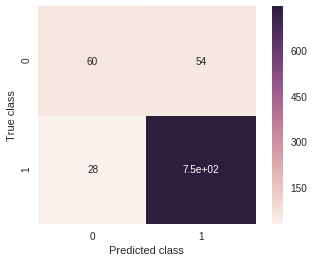

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

C = confusion_matrix(validation_generator_noshuffle.classes, predictions > .5)
ax = sns.heatmap(C, annot=True, square=True)
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')

precision = C[0,0] / (C[0,0] + C[1,0])
recall = C[0][0] / (C[0,0] + C[0,1])

print(precision, recall)

Oh. Right. That means that only 68.2% of our predicted hotdogs are such, and that we only detect around 52.6% of all the hotdogs in the dataset. That is, when our users get a "hotdog" prediction, the probability that they are pointing at a hotdog will be under 70%. Not awful, but definitely worse sounding than 90% accuracy. Moreover, the real problem is in the other metric, recall. That value means that when they point at a hotdog, the probability that the app recognizes it is only 52%! Not a great user experience. In short, our classifier is being way too cautious. It doesn't risk a "hotdog" prediction very often, and therefore it is not wrong very often. 

That illustrates a very important idea to keep in mind: choose the right metrics! Specially in unbalanced datasets, accuracy can be pretty misleading. We are fitting on binary cross entropy, which will naturally focus on getting right the most common class. In order to compensate for the fact that we have many more nothotdogs than hotdogs, `fit_generator` provides a `class_weight` parameter that allows us to artificially give more importance to underrepresented or specially important classes. Let's try it:

In [4]:
%%time
from keras.optimizers import Adam

my_first_cnn.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-3),
                     metrics=['acc'])

history = my_first_cnn.fit_generator(train_generator,
                                     class_weight = {0: 7, 1: 1},
                                     steps_per_epoch=30,
                                     epochs=10,
                                     validation_data=validation_generator,
                                     validation_steps=10)

Epoch 1/10
30/30 [==============================] - 20s 654ms/step - loss: 0.5548 - acc: 0.8560 - val_loss: 0.3427 - val_acc: 0.8543
Epoch 2/10
30/30 [==============================] - 19s 617ms/step - loss: 0.4314 - acc: 0.8891 - val_loss: 0.3274 - val_acc: 0.8654
Epoch 3/10
30/30 [==============================] - 18s 594ms/step - loss: 0.4156 - acc: 0.8941 - val_loss: 0.3274 - val_acc: 0.8664
Epoch 4/10
30/30 [==============================] - 18s 603ms/step - loss: 0.3210 - acc: 0.9103 - val_loss: 0.2864 - val_acc: 0.8846
Epoch 5/10
30/30 [==============================] - 19s 645ms/step - loss: 0.3397 - acc: 0.9089 - val_loss: 0.2929 - val_acc: 0.8715
Epoch 6/10
30/30 [==============================] - 20s 654ms/step - loss: 0.2801 - acc: 0.9217 - val_loss: 0.3418 - val_acc: 0.8535
Epoch 7/10
30/30 [==============================] - 19s 638ms/step - loss: 0.2595 - acc: 0.9333 - val_loss: 0.3745 - val_acc: 0.8472
Epoch 8/10
30/30 [==============================] - 19s 634ms/step - 

This time the confusion matrix is this one:

0.5714285714285714 0.7368421052631579


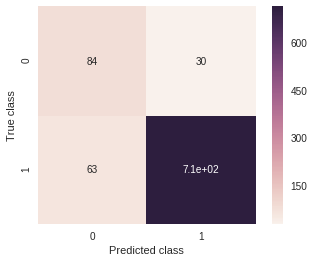

In [5]:
validation_generator_noshuffle.reset()
predictions = my_first_cnn.predict_generator(validation_generator_noshuffle, steps=9)

C = confusion_matrix(validation_generator_noshuffle.classes, predictions > .5)
ax = sns.heatmap(C, annot=True, square=True)
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')

precision = C[0,0] / (C[0,0] + C[1,0])
recall = C[0][0] / (C[0,0] + C[0,1])

print(precision, recall)

Much better! This won't blow Jian-Yang away, but it's a a lot better, despite having worse accuracy. Consider that before this morning, you had no idea how to code a program to have some perception of the real world. Now you can!

Anyway, we have a classifier. It's not great, but I'm sure it can get better. Let's train it a bit more, shall we?

In [6]:
%%time
from keras.optimizers import Adam

my_first_cnn.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-3),
                     metrics=['acc'])

history_pt2 = my_first_cnn.fit_generator(train_generator,
                                         class_weight = {0: 7, 1: 1},
                                         steps_per_epoch=30,
                                         epochs=20,
                                         validation_data=validation_generator,
                                         validation_steps=10,
                                         verbose=1)

Epoch 1/20
30/30 [==============================] - 21s 695ms/step - loss: 0.2010 - acc: 0.9458 - val_loss: 0.2855 - val_acc: 0.9038
Epoch 2/20
30/30 [==============================] - 20s 667ms/step - loss: 0.1412 - acc: 0.9640 - val_loss: 0.3392 - val_acc: 0.8947
Epoch 3/20
30/30 [==============================] - 19s 631ms/step - loss: 0.1366 - acc: 0.9660 - val_loss: 0.3653 - val_acc: 0.8801
Epoch 4/20
30/30 [==============================] - 19s 649ms/step - loss: 0.1380 - acc: 0.9651 - val_loss: 0.3499 - val_acc: 0.8998
Epoch 5/20
30/30 [==============================] - 19s 634ms/step - loss: 0.1279 - acc: 0.9697 - val_loss: 0.3525 - val_acc: 0.9008
Epoch 6/20
30/30 [==============================] - 18s 609ms/step - loss: 0.0691 - acc: 0.9843 - val_loss: 0.3608 - val_acc: 0.9109
Epoch 7/20
30/30 [==============================] - 20s 657ms/step - loss: 0.0847 - acc: 0.9823 - val_loss: 0.3751 - val_acc: 0.9099
Epoch 8/20
30/30 [==============================] - 20s 677ms/step - 

What's happening here? We are seeing a typical case of overfitting. Our training loss is improving really fast, but at the same time the validation loss increases in each epoc. The network is learning the specific details of the training set, which don't generalize all that well to the samples in the validation set. 

We can appreciate that by plotting loss and validation loss over training. At some point, our loss keeps improving (going down), but validation loss keeps getting worse. The detector is getting hung up on the minor specificities of the training set.

CPU times: user 128 ms, sys: 4.17 ms, total: 132 ms
Wall time: 80.7 ms


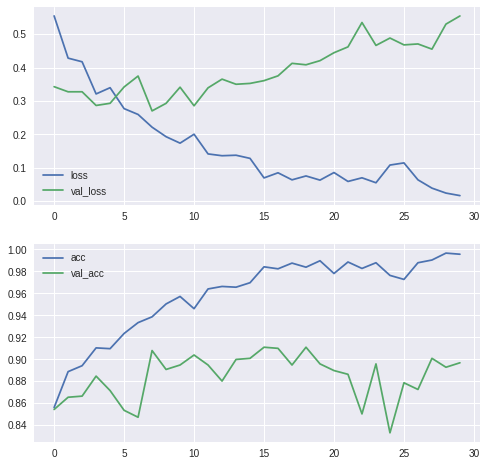

In [7]:
%%time
import matplotlib.pyplot as plt

f, axes = plt.subplots(2,1)

f.set_size_inches(8,8)

nb_epochs = len(history.epoch)
concatenated = history.epoch + [nb_epochs + epoch_number for epoch_number in history_pt2.epoch]

axes[0].plot(concatenated, history.history['loss'] + history_pt2.history['loss'], label='loss')
axes[0].plot(concatenated, history.history['val_loss'] + history_pt2.history['val_loss'], label='val_loss')
axes[0].legend()

axes[1].plot(concatenated, history.history['acc'] + history_pt2.history['acc'], label='acc')
axes[1].plot(concatenated, history.history['val_acc'] + history_pt2.history['val_acc'], label='val_acc')
axes[1].legend()

The effect will be obvious if we check the confusion matrix on the validation set again. Remember, this is a classifier that gets 99.6% of the items in the training set right!

0.578125 0.6491228070175439
CPU times: user 6.23 s, sys: 128 ms, total: 6.36 s
Wall time: 5.62 s


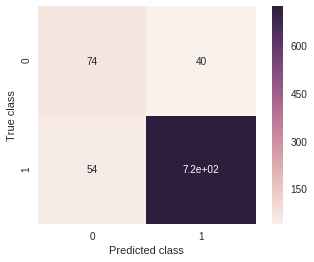

In [8]:
%%time
validation_generator_noshuffle.reset()
predictions = my_first_cnn.predict_generator(validation_generator_noshuffle, steps=9)

C = confusion_matrix(validation_generator_noshuffle.classes, predictions > .5)
ax = sns.heatmap(C, annot=True, square=True)
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')

precision = C[0,0] / (C[0,0] + C[1,0])
recall = C[0][0] / (C[0,0] + C[0,1])

print(precision, recall)

And despite that 99.6%, it's not any better than the previous version. In fact, it's worse.

This is the tightrope act that we must make all the time when practising Machine Learning: the [bias-variance tradeoff]. In short, that refers to the trade-off between flexibility and generality of the models. A sufficiently flexible (read: complicated) model will always be able to learn non-relevant details of the input dataset (to overfit), and Neural Networks are nothing if not complicated: notice above where we built our simple CNN: it has over $10^6$ parameters! That's over a million knobs to tweak.

Overfitting means we have high variance: different samples will lead to very different estimations of the parameters. That will manifest as higher validation loss than training loss, as we see here from about epoch 8.

The solutions are simple but varied, and we need to keep many of them in our bag of tools for different occasions. Some are very general and some are pretty specific, but all of them fall under the heading of [regularization]. [This] is probably the best explanation of that that I've heard. In short, we want to penalize somehow the complexity of our models. That will in turn result in better generality.

In our specific example, image recognition, there's one very intuitive way to make our model recognize more varied images of hotdogs: to feed it more varied images of hotdogs. Since we already collected as many as we could, what we can do is to _generate_ more varied images of hotdogs. 

And that is exactly what we'll do in the next installment of this series.

[bias-variance tradeoff]: https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff
[regularization]: https://en.wikipedia.org/wiki/Regularization_(mathematics)#Generalization
[This]: https://www.coursera.org/lecture/machine-learning/regularization-and-bias-variance-4VDlf

### Further Reading

[Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python): A great introductory book by  François Chollet, author of Keras. Explains the practice first, then goes down to theory.

[Interview with François Chollet](https://www.pyimagesearch.com/2018/07/02/an-interview-with-francois-chollet/), author of DL with Python.

[Implementing a Neural Network from scratch with Python](https://medium.com/@curiousily/tensorflow-for-hackers-part-iv-neural-network-from-scratch-1a4f504dfa8): An in depth view of the internal architecture of a NN, with a tutorial to implement backpropagation.

[Activation functions and their types](https://towardsdatascience.com/activation-functions-and-its-types-which-is-better-a9a5310cc8f): A nice discussion of activation functions.